In [1]:
%matplotlib inline
%matplotlib notebook
import os
import cv2
from PIL import Image
import numpy as np
import torch
#from torch import nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#import pytorch_lightning as pl

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(241, 241)


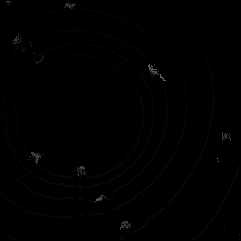

In [8]:
with Image.open("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev/4.png") as img:
    print(img.size)
    display(img)

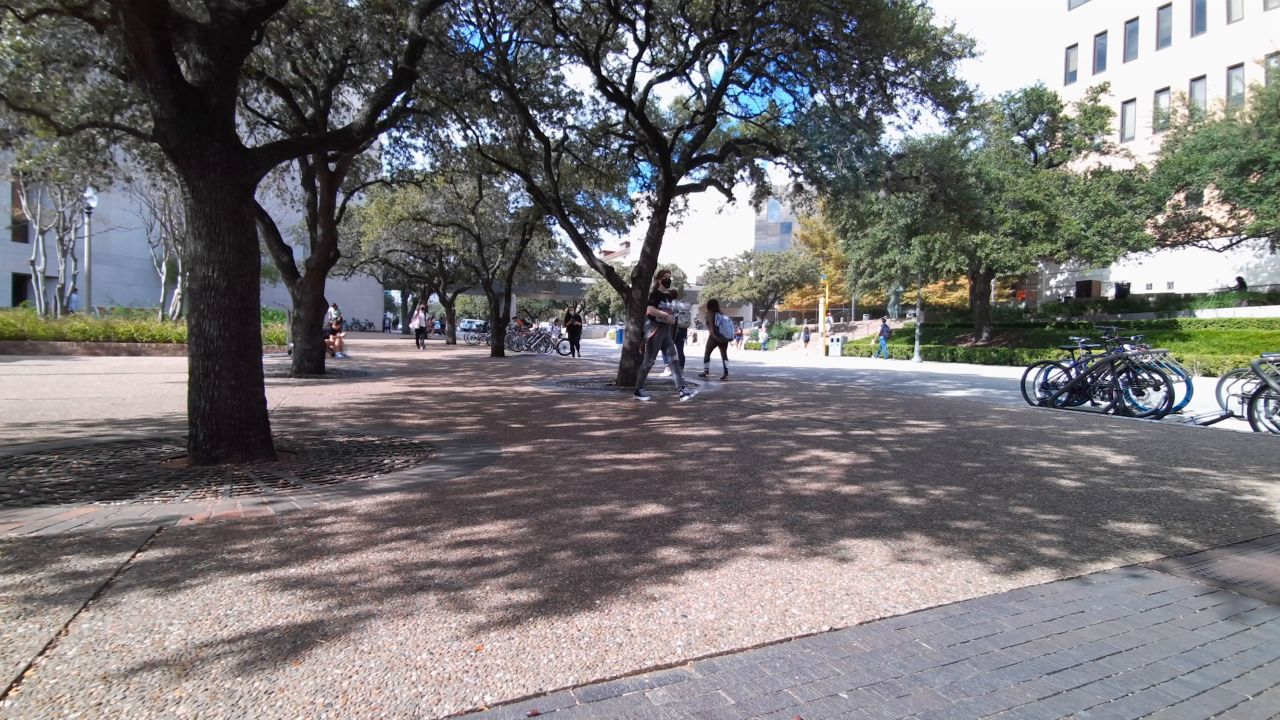

<IPython.core.display.Javascript object>


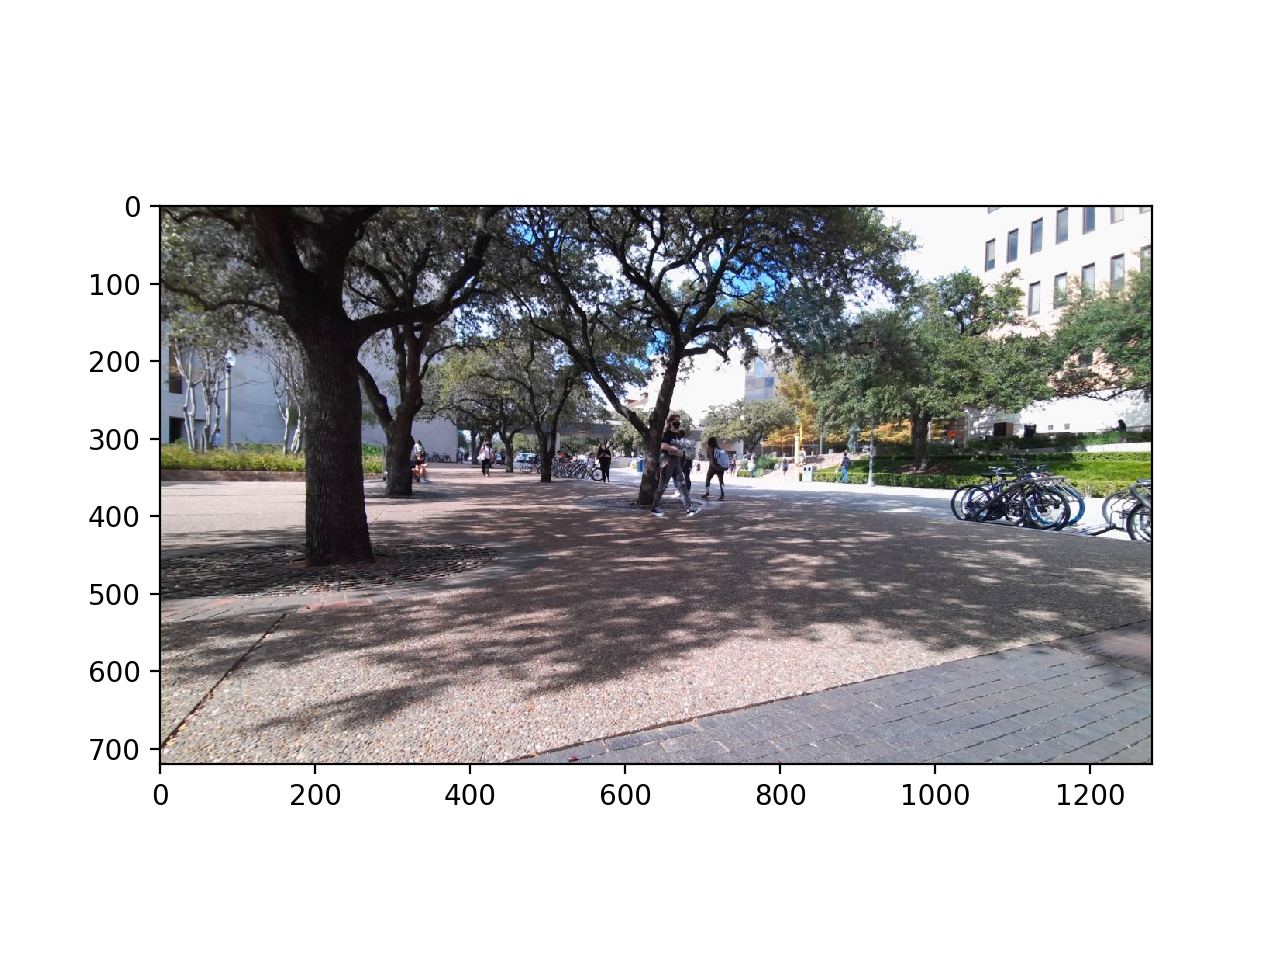

In [5]:
with Image.open("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_rgb_img/0.png") as img:
    display(img)
    plt.imshow(img)

In [14]:
bev_frms = [file for file in os.listdir("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev")]
len(bev_frms)

2062

<IPython.core.display.Javascript object>


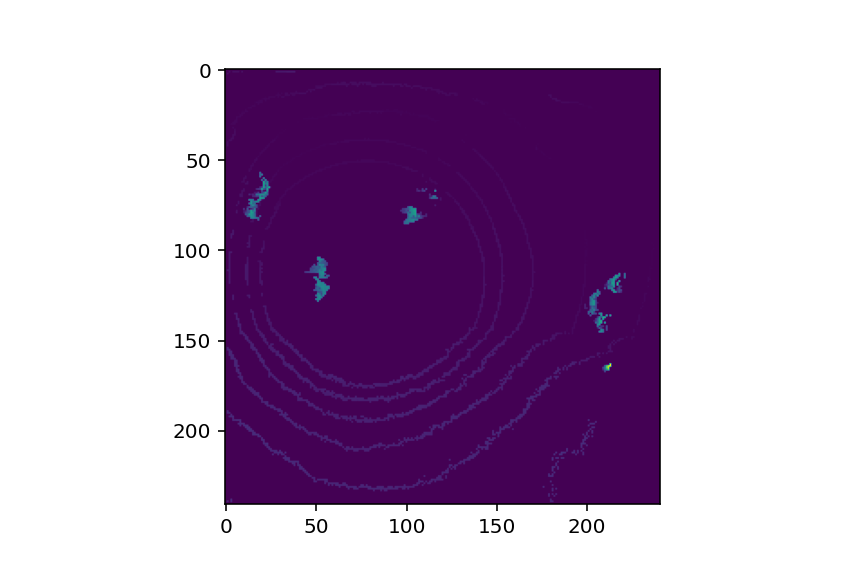

In [14]:
fig, ax = plt.subplots()
ims = []
idx = 957
for i in range(idx,idx + 50):
    with Image.open(f"./data/A_Spot_Butler_Foodtruck_Fri_Nov_26_132_lidar_bev/{i}.png") as img:
        im = ax.imshow(img, animated=True)
        if i == 0:
            ax.imshow(img)  # show an initial one first
        ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
plt.show()

<IPython.core.display.Javascript object>


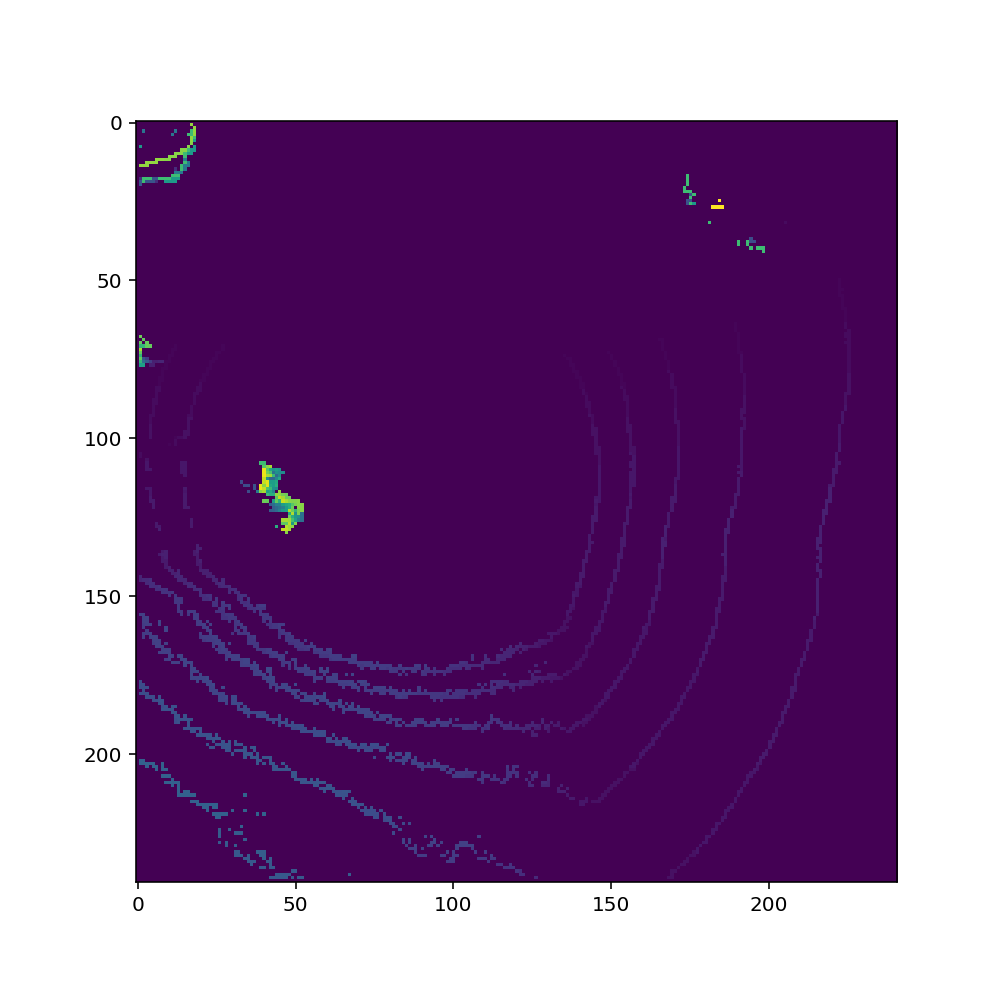

(241, 241)


<IPython.core.display.Javascript object>


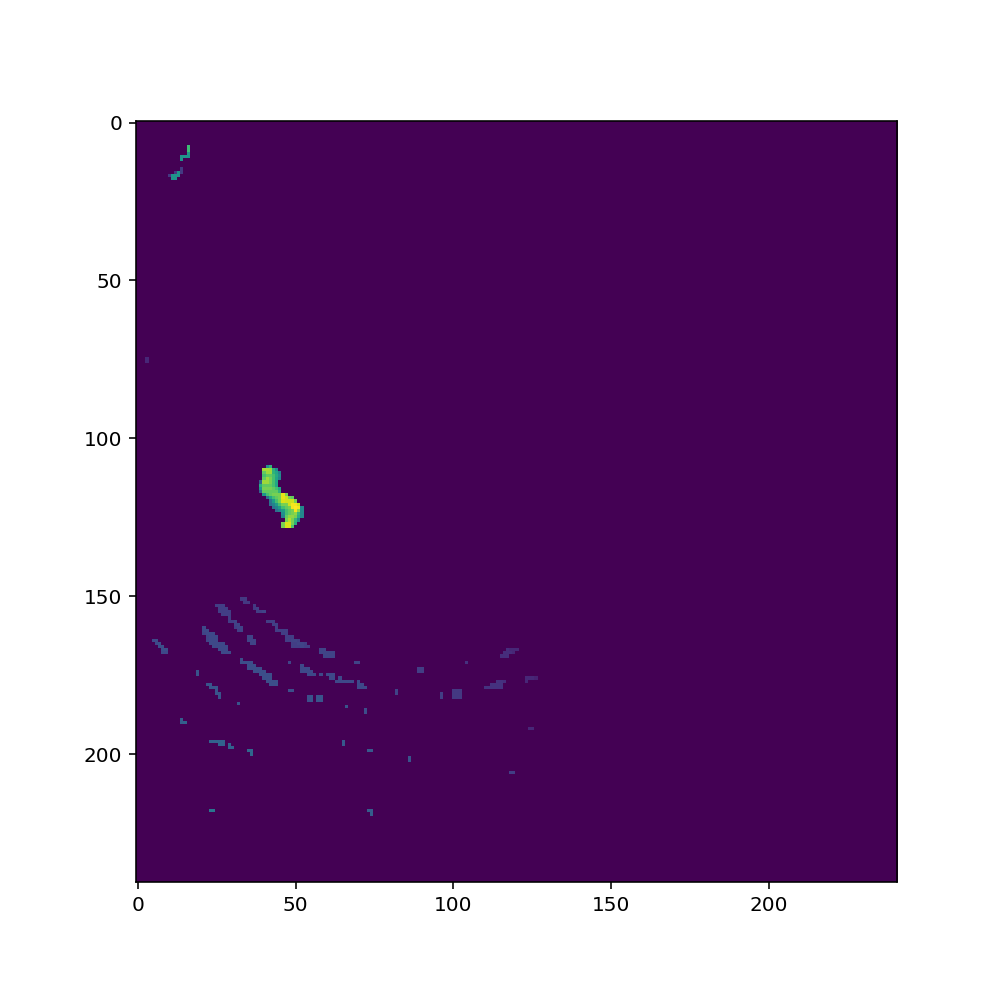

<IPython.core.display.Javascript object>


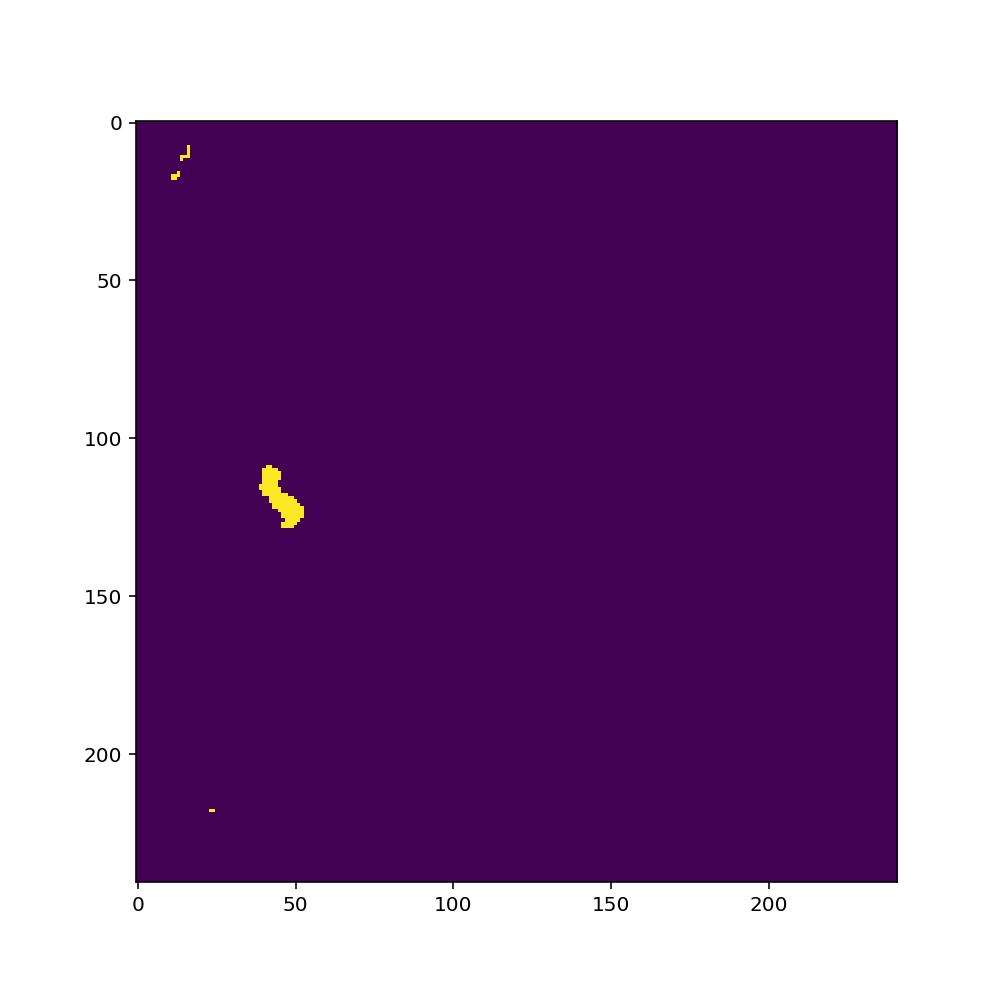

In [3]:
img = cv2.imread("./data/A_Spot_Butler_Foodtruck_Fri_Nov_26_132_lidar_bev/86.png", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(7,7))
plt.imshow(img)
#img = cv2.GaussianBlur(img, (7, 7), 0)
img = cv2.medianBlur(img, 5)
print(img.shape)
plt.figure(figsize=(7,7))
plt.imshow(img)
img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(7,7))
plt.imshow(img)

In [4]:
output = cv2.connectedComponentsWithStats(img, 8)
(numLabels, labels, stats, centroids) = output
output

# min area = 10
# max area = 70
# min height/width = 3
# max height/width = 15

(5,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 array([[    0,     0,   241,   241, 57937],
        [   14,     8,     3,     5,     7],
        [   11,    16,     3,     3,     6],
        [   39,   109,    14,    20,   129],
        [   23,   218,     2,     1,     2]], dtype=int32),
 array([[120.19357233, 120.02281789],
        [ 15.28571429,  10.28571429],
        [ 12.        ,  17.16666667],
        [ 45.26356589, 118.96899225],
        [ 23.5       , 218.        ]]))

In [8]:
import math
objs = []
for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]

    if((area>10) and (area<70)):
        objs.append(centroids[i])
objs = np.array(objs)
for obj in objs:
    print(obj)

[106.38095238  42.96825397]
[19.6   70.975]
[ 36.39534884 117.02325581]
[ 15.77777778 134.38888889]


[INFO] examining component 11/16
(241, 241, 3)


<IPython.core.display.Javascript object>


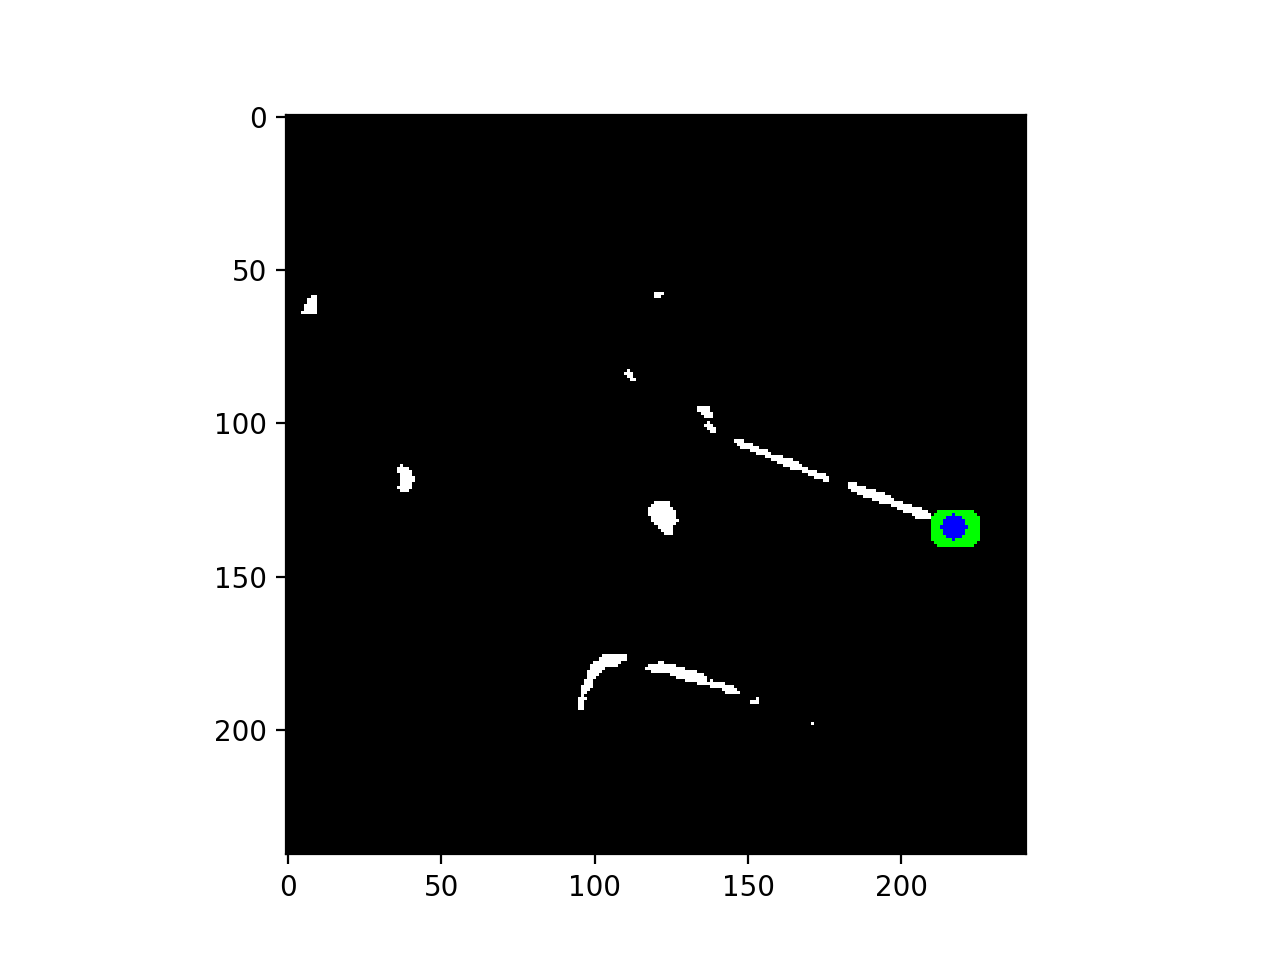

In [111]:
i = 10
# if this is the first component then we examine the
# *background* (typically we would just ignore this
# component in our loop)
if i == 0:
    text = "examining component {}/{} (background)".format(
        i + 1, numLabels)
# otherwise, we are examining an actual connected component
else:
    text = "examining component {}/{}".format( i + 1, numLabels)
# print a status message update for the current connected
# component
print("[INFO] {}".format(text))
# extract the connected component statistics and centroid for
# the current label
x = stats[i, cv2.CC_STAT_LEFT]
y = stats[i, cv2.CC_STAT_TOP]
w = stats[i, cv2.CC_STAT_WIDTH]
h = stats[i, cv2.CC_STAT_HEIGHT]
area = stats[i, cv2.CC_STAT_AREA]
(cX, cY) = centroids[i]

output = img.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
print(output.shape)
plt.figure()
plt.imshow(output)

In [2]:
import pickle
from data_prep.MOTrajectory import extract_traj
pose_data = pickle.load(open("./data/A_Spot_Butler_Foodtruck_Fri_Nov_26_132_pose.pkl", 'rb'))
idx = 957
#print(pose_data['pose_sync'][idx])
poses = pose_data['pose_sync'][idx:idx+50]
traj = extract_traj("./data/A_Spot_Butler_Foodtruck_Fri_Nov_26_132_lidar_bev", idx, poses, 50)
print(len(traj))

12


In [20]:
a = torch.from_numpy(np.array(traj)).to(torch.float32)
b = a.unsqueeze(dim=0)
B, O, N, C = b.shape
c = torch.zeros(B,O,2).unsqueeze(dim=2)
c = torch.cat([c,b], dim=2)
c.shape
c[:,:,:-1].shape

torch.Size([1, 12, 50, 2])

In [26]:
import math
n_idx = 7
print(len(traj[n_idx]))
dist = []
for i in range(len(traj[n_idx])):
    dist.append(math.dist(traj[n_idx][0], traj[n_idx][i]))
print(np.std(dist))
np.array(traj[n_idx])

51
1.734210298238042


array([[ 7.39231625, -0.76602988],
       [ 7.39231625, -0.76602988],
       [ 7.39231625, -0.76602988],
       [ 7.39231625, -0.76602988],
       [ 7.5454518 , -0.74992431],
       [ 7.70375188, -0.77572089],
       [ 7.75433737, -0.80201121],
       [ 7.75433737, -0.80201121],
       [ 8.11246259, -0.78520566],
       [ 8.17599752, -0.77595932],
       [ 8.33795346, -0.82604398],
       [ 8.33795346, -0.82604398],
       [ 8.55562061, -0.87294934],
       [ 8.64559832, -0.83411753],
       [ 8.88818523, -0.94061053],
       [ 8.93113375, -0.91732419],
       [ 9.10290729, -0.92464388],
       [ 9.20439764, -0.89425271],
       [ 9.32385751, -0.9355673 ],
       [ 9.47562572, -0.98465685],
       [ 9.65227941, -0.97772248],
       [ 9.74372987, -0.9916696 ],
       [ 9.86945699, -1.03213722],
       [ 9.86945699, -1.03213722],
       [10.05329451, -1.02092225],
       [10.21362114, -1.01272757],
       [10.30454854, -1.10391537],
       [10.47634676, -1.05404597],
       [10.61290069,

<IPython.core.display.Javascript object>


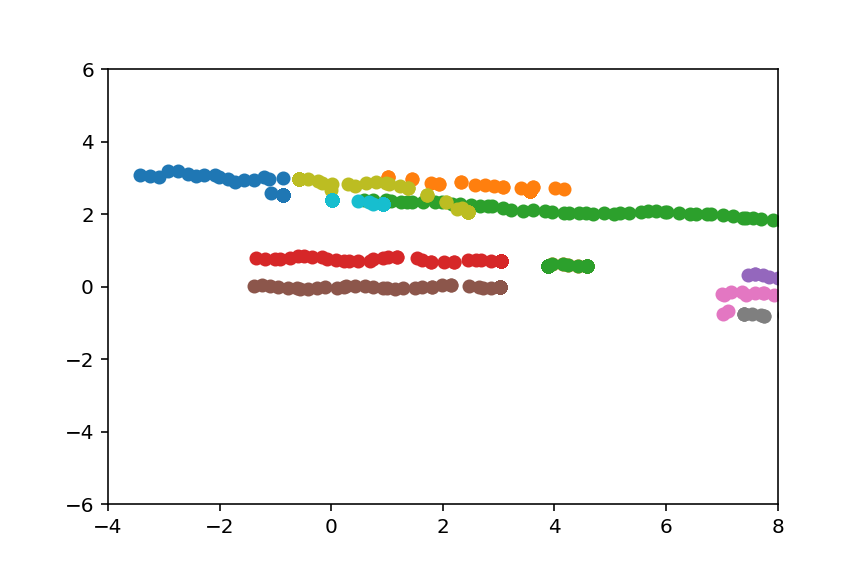

(-6.0, 6.0)

In [5]:
plt.figure()
# obj_idx = 7
# traj_np = np.array(traj[obj_idx])
for i,t in enumerate(traj):
    traj_np = np.array(t)
    plt.scatter(traj_np[:,0], traj_np[:,1], label=f"{i}")
plt.scatter(traj_np[:,0], traj_np[:,1],)
plt.xlim(-4, 8)
plt.ylim(-6, 6)

In [2]:
from models.dataloader import NavSet, NavSetDataModule
from models.encoder import VisionTransformer
from models.decoder import TransformerDecoder
from models.model import AttnNav
from torch.utils.data import DataLoader, ConcatDataset

In [3]:
trainset = NavSet("./data", "./data/A_Spot_Library_AHG_Tue_Nov_9_43.bag")
print(trainset.__len__())

3291


In [4]:
trainset2 = NavSet("./data", "./data/A_Spot_Library_AHG_Tue_Nov_9_43.bag")
print(trainset2.__len__())
valset2 = NavSet("./data", "./data/A_Spot_Library_AHG_Tue_Nov_9_43.bag", is_train=False)
print(valset2.__len__())

trainset = ConcatDataset([trainset1, trainset2])
valset = ConcatDataset([valset1, valset2])

3291


TypeError: __init__() got an unexpected keyword argument 'is_train'

In [5]:
bs = 2
trainloader = DataLoader(trainset, batch_size=bs, num_workers=8, pin_memory=True)
#valloader = DataLoader(valset, batch_size=bs, num_workers=8, pin_memory=True)
print(trainset[204][2])
for i, (image, lidar, pose) in enumerate(trainloader):
    print(pose)
    break
plt.figure()
idx = 353
rob_traj = trainset[idx][2].numpy()
plt.scatter(rob_traj[:,0], rob_traj[:,1])
plt.xlim(-4,10)
plt.ylim(-6,6)

tensor([[ 1.5289e-01, -2.2040e-03],
        [ 2.4576e-01, -3.3485e-03],
        [ 3.4568e-01, -2.6529e-03],
        [ 4.1679e-01, -3.0357e-03],
        [ 4.8788e-01, -1.0379e-03],
        [ 5.8242e-01, -4.4040e-03],
        [ 6.6223e-01, -7.4882e-03],
        [ 7.4732e-01, -1.1598e-02],
        [ 8.2894e-01, -1.5503e-02],
        [ 9.0460e-01, -1.9171e-02],
        [ 9.8503e-01, -1.7585e-02],
        [ 1.0880e+00, -1.7071e-02],
        [ 1.1745e+00, -1.3694e-02],
        [ 1.2683e+00, -8.1064e-03],
        [ 1.3332e+00, -5.3450e-04],
        [ 1.4117e+00,  4.6712e-03],
        [ 1.5197e+00,  1.3929e-02],
        [ 1.6280e+00,  2.2021e-02],
        [ 1.7168e+00,  3.1989e-02],
        [ 1.7812e+00,  3.7789e-02],
        [ 1.8625e+00,  4.8839e-02],
        [ 1.9561e+00,  6.1530e-02],
        [ 2.0372e+00,  7.4964e-02],
        [ 2.1233e+00,  8.9859e-02],
        [ 2.1971e+00,  1.0491e-01],
        [ 2.2729e+00,  1.1785e-01],
        [ 2.3670e+00,  1.3369e-01],
        [ 2.4651e+00,  1.501

ValueError: too many values to unpack (expected 3)

In [14]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = AttnNav().to(device)
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2])

batch_size = 16
criterion = nn.MSELoss(reduction = 'sum').to(device)
learning_rate = 0.00003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20
trainSteps = len(trainset) // batch_size
testSteps = len(valset) // batch_size

cuda


In [15]:
H = {"train_loss": [], "val_loss": []}

for e in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    #adjust_learning_rate(optimizer, e, num_epochs, learning_rate)
    
    for i, (image, lidar, pose) in enumerate(trainloader):
        (image, lidar, pose) = (image.to(device), lidar.to(device), pose.to(device))
        output = model(image, lidar, pose)
        
        loss = criterion(output, pose)
        #print(torch.cuda.memory_summary(device=None, abbreviated=False))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().item()
    
    with torch.no_grad():
        model.eval()
        
        for (image, lidar, pose) in valloader:
            (image, lidar, pose) = (image.to(device), lidar.to(device), pose.to(device))
            pred = model(image, lidar, pose)
            p_loss = criterion(pred, pose)
            val_loss += p_loss.item()
    
        avgTrainloss = train_loss/trainSteps
        avgValloss = val_loss/testSteps
    
    H["train_loss"].append(avgTrainloss)
    H["val_loss"].append(avgValloss)
    
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Validation loss: {:.4f}'.format(e, num_epochs, avgTrainloss, avgValloss))

RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 23.70 GiB total capacity; 7.06 GiB already allocated; 41.06 MiB free; 7.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<IPython.core.display.Javascript object>


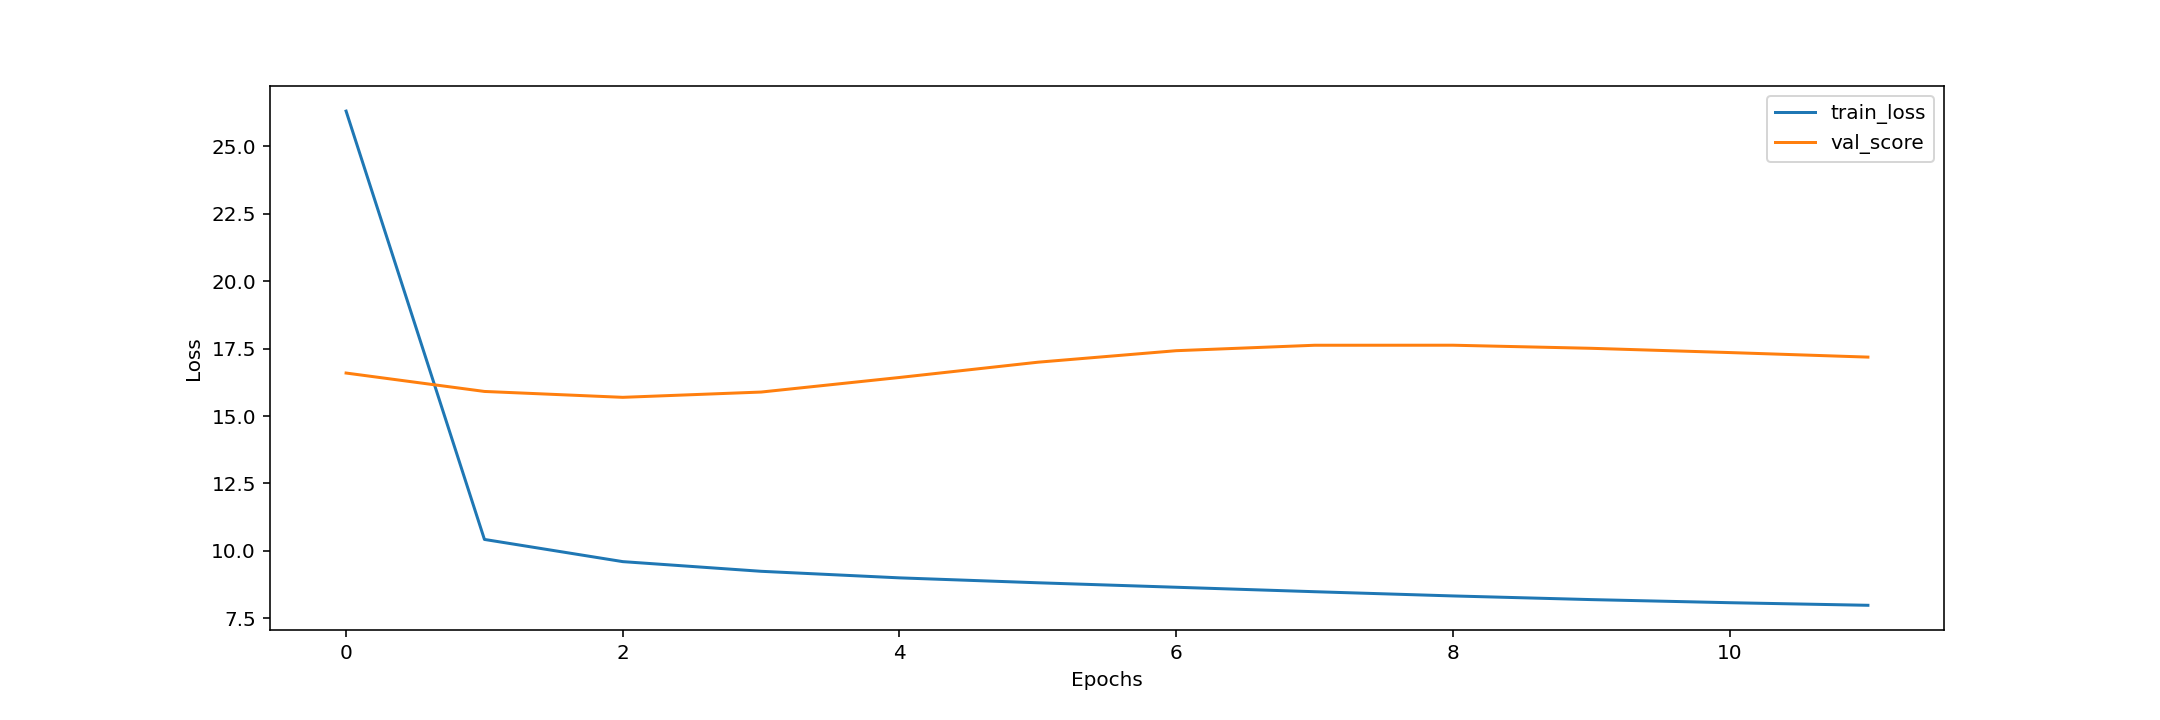

In [7]:
def plot_loss(train_loss, val_loss, num_epochs):   
    fig = plt.figure(figsize=[15,5])
    plt.plot(range(num_epochs), train_loss, label='train_loss')
    plt.plot(range(num_epochs), val_loss, label='val_score')

    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
plot_loss(H['train_loss'], H['val_loss'], 12)

In [29]:
torch.cuda.device_count()

3

In [31]:
torch.__version__

'1.13.0a0+08820cb'

In [10]:
a = "readu:=" + '"st.bf"'
a

'readu:="st.bf"'

In [3]:
encoder1 = VisionTransformer(input_channels=1)
encoder2 = VisionTransformer()
decoder = TransformerDecoder()

model = AttnNav(encoder2, encoder1, decoder)
dm = NavSetDataModule("./data", "./data/train_bags", "./data/val_bags")

13
4


In [4]:
from pytorch_lightning import Trainer
trainer = Trainer(
        accelerator='gpu',
        gpus=1,
        limit_train_batches=10, limit_val_batches=5,
        #logger=pl_loggers.TensorBoardLogger("lightning_logs/clip_social_nav/"),
        #callbacks=[model_checkpoint_cb, swa_cb],
        #gradient_clip_val=1.0,
        max_epochs=2,
        log_every_n_steps=2)

# fit model
trainer.fit(model, dm)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache

Epoch 0:  67%|████████████████        | 10/15 [00:03<00:01,  3.05it/s, loss=443, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████| 15/15 [00:04<00:00,  3.05it/s, loss=443, v_num=11, val_loss=75.00]
Epoch 1:  67%|▋| 10/15 [00:03<00:01,  2.96it/s, loss=255, v_num=11, val_loss=75.00, train_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                      | 0/5 [00:00<?, ?it/s]
Epoch 1:  73%|▋| 11/15 [00:04<00:01,  2.28it/s, loss=255, v_num=11, val_loss=75.00, train_
Epoch 1:  80%|▊| 12/15 [00:04<00:01,  2.47it/s, loss=255, v_num=11, val_loss=75.00, train_
Epoch 1:  87%|▊| 13/15 [00:04<00:00,  2.64it/s, loss=255, v_num=11, val_loss=75.00, train_
Epoch 1:  93%|▉| 14/15 [00:04<00:00,  2.80it/s, loss=255, v_num=11, val_loss=75.00, train_
Epoch 1: 100%|█| 15/15 [00:05<00:00,  2.93it/s, loss=255, v_num=11, val_loss=64.80, train_
Epoch 1: 100%|█| 15/15 [00:05<00:00,  2.93it/s, loss=255, v_num=11, val_loss=64.80, train_

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|█| 15/15 [00:05<00:00,  2.70it/s, loss=255, v_num=11, val_loss=64.80, train_


In [9]:
a = [b for b in os.listdir("./data/train_bags") if os.path.isfile(os.path.join("./data/train_bags",b))]
a

['A_Spot_Fountain_Library_Mon_Nov_8_26.bag',
 'A_Spot_AHG_Library_Wed_Nov_10_46.bag',
 'A_Spot_Butler_Foodtruck_Fri_Nov_26_132.bag',
 'A_Spot_Bass_Rec_Fri_Nov_26_126.bag',
 'A_Spot_Stadium_Rec_Fri_Nov_26_135.bag',
 'A_Spot_AHG_Library_Fri_Nov_5_21.bag',
 'A_Spot_Stadium_PerformingArtsCenter_Sat_Nov_13_106.bag',
 'A_Spot_GDC_Jester_Thu_Nov_18_121.bag',
 'A_Spot_Library_AHG_Tue_Nov_9_43.bag',
 'A_Spot_Parlin_Parlin_Wed_Nov_10_51.bag',
 'A_Spot_LBJ_Stadium_Sat_Nov_13_105.bag',
 'A_Spot_EER_AHG_Mon_Nov_8_32.bag',
 'A_Spot_Library_Dobie_Wed_Nov_10_57.bag']

In [8]:
os.path.isfile(a[0])

False

In [7]:
from pytorch_lightning import Trainer
trainer = Trainer(
        accelerator='gpu',
        gpus=1,
        #logger=pl_loggers.TensorBoardLogger("lightning_logs/clip_social_nav/"),
        #callbacks=[model_checkpoint_cb, swa_cb],
        #gradient_clip_val=1.0,
        max_epochs=2,
        log_every_n_steps=20)

# fit model
trainer.fit(model, dm)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type               | Params
-----------------------------------------------------
0 | rgb_encoder   | VisionTransformer 

Epoch 0:   3%| | 79/2452 [00:19<09:38,  4.10it/s, loss=1.55, v_num=2, train_loss_step=0.75

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [4]:
from train import train

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_7641/3058615774.py", line 1, in <cell line: 1>
    from train import train
  File "/workspace/project/train/train.py", line 35, in <module>
    datamodel = NavSetDataModule(save_data_path=CFG.save_data_path,
  File "/workspace/project/models/dataloader.py", line 103, in __init__
    self.train_bags = [b for b in os.listdir(train_rosbag_path) if os.path.isfile(os.path.join(train_rosbag_path,b))]
FileNotFoundError: [Errno 2] No such file or directory: '../data/train_bags/'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/conda/lib/python3.8/site-pac

In [4]:
from datetime import datetime
import torch
from pytorch_lightning import Trainer
import pytorch_lightning.loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging, ModelCheckpoint

from models.model import AttnNav
from models.dataloader import NavSetDataModule
import train.config as CFG

# training callbacks
early_stopping_cb = EarlyStopping(monitor='val_loss',
                                  mode='min',
                                  min_delta=0.00,
                                  patience=10)
swa_cb = StochasticWeightAveraging(swa_lrs=1e-2)
model_checkpoint_cb = ModelCheckpoint(
    dirpath='trained_models/',
    filename=datetime.now().strftime("%d-%m-%Y-%H-%M-%S"),
    monitor='val_loss',
    mode='min')

model = AttnNav(img_size=CFG.img_size,
                patch_size=CFG.patch_size,
                embed_dim=CFG.embed_dim,
                depth=CFG.depth,
                num_heads=CFG.num_heads,
                drop_rate=CFG.drop_rate,
                attn_drop_rate=CFG.attn_drop_rate,
                drop_path_rate=CFG.drop_path_rate,
                lr=CFG.learning_rate,
                optimizer=CFG.optimizer,
                weight_decay=CFG.weight_decay)

datamodel = NavSetDataModule(save_data_path=CFG.save_data_path,
                             train_rosbag_path=CFG.train_rosbag_path,
                             val_rosbag_path=CFG.val_rosbag_path,
                             batch_size=6,
                             num_workers=CFG.num_workers,
                             pin_memory=CFG.pin_memory)

num_gpus = torch.cuda.device_count()
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    #strategy='ddp',
    logger=pl_loggers.TensorBoardLogger("logs/"),
    #callbacks=[model_checkpoint_cb, early_stopping_cb],
    gradient_clip_val=1.0,
    max_epochs=CFG.epochs,
    log_every_n_steps=20)

print("Starting training!!!")

trainer.fit(model, datamodel)

print('Model has been trained and saved!')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


13
4
Starting training!!!


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type               | Params
-----------------------------------------------------
0 | rgb_encoder   | VisionTransformer  | 6.6 M 
1 | lidar_encoder | VisionTransformer  | 6.6 M 
2 | decoder       | TransformerDecoder | 8.4 M 
3 | criterion     | MSELoss            | 0     
-----------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.548    Total estimated model params size (MB)


Epoch 0:   0%|                                                   | 0/6538 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 23.70 GiB total capacity; 7.00 GiB already allocated; 51.06 MiB free; 7.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [2]:
!python3 -m train.train

13
4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Starting training!!!
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
13
4
Starting training!!!
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3
13
4
Starting training!!!
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 3 processes
----------------------------------------------------------------------------------------------------

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_pr

In [2]:
import bagpy
from bagpy import bagreader
#SocialNav/data/train_bags/A_Spot_AHG_Library_Fri_Nov_5_21.bag

In [5]:
b = bagreader("./data/train_bags/A_Spot_Parlin_Parlin_Wed_Nov_10_51.bag")
b.topic_table

[INFO]  Successfully created the data folder ./data/train_bags/A_Spot_Parlin_Parlin_Wed_Nov_10_51.


Topics                        Types  \
0                      /image_raw/compressed  sensor_msgs/CompressedImage   
1                              /joint_states       sensor_msgs/JointState   
2                                  /joystick              sensor_msgs/Joy   
3                              /localization  amrl_msgs/Localization2DMsg   
4                        /navigation/cmd_vel          geometry_msgs/Twist   
5                                      /odom            nav_msgs/Odometry   
6                                      /scan        sensor_msgs/LaserScan   
7              /spot/camera/back/camera_info       sensor_msgs/CameraInfo   
8         /spot/camera/back/image/compressed  sensor_msgs/CompressedImage   
9         /spot/camera/frontleft/camera_info       sensor_msgs/CameraInfo   
10   /spot/camera/frontleft/image/compressed  sensor_msgs/CompressedImage   
11       /spot/camera/frontright/camera_info       sensor_msgs/CameraInfo   
12  /spot/camera/frontright/image/compressed  sensor_msgs/CompressedImage   
13             /spot/camera/left/camera_info       sensor_msgs/CameraInfo   
14        /spot/camera/left/image/compressed  sensor_msgs/CompressedImage   
15            /spot/camera/right/camera_info       sensor_msgs/CameraInfo   
16       /spot/camera/right/image/compressed  sensor_msgs/CompressedImage   
17                                       /tf           tf2_msgs/TFMessage   
18                          /velodyne_points      sensor_msgs/PointCloud2   

    Message Count  Frequency  
0            2127  29.997239  
1            1194  16.399503  
2            4350  60.005208  
3            1195  16.568912  
4            2909  40.006715  
5            1194  16.505730  
6             721   9.915167  
7             326   4.477243  
8             326   4.478745  
9             325   4.471444  
10            325   4.466754  
11            325   4.471754  
12            325   4.463084  
13            325   4.475965  
14            325   4.474001  
15            325   4.476314  
16            325   4.479335  
17           4807  51.309295  
18            721   9.915507

In [5]:
a = [1,3,4,5,6]
a[2:4]

[4, 5]

In [5]:
os.listdir("./data/train_bags") + os.listdir("./data/val_bags")

['A_Spot_Fountain_Library_Mon_Nov_8_26.bag',
 'A_Spot_AHG_Library_Wed_Nov_10_46.bag',
 'A_Spot_Butler_Foodtruck_Fri_Nov_26_132.bag',
 'A_Spot_Bass_Rec_Fri_Nov_26_126.bag',
 'A_Spot_Stadium_Rec_Fri_Nov_26_135.bag',
 'A_Spot_AHG_Library_Fri_Nov_5_21.bag',
 'A_Spot_Stadium_PerformingArtsCenter_Sat_Nov_13_106.bag',
 'A_Spot_GDC_Jester_Thu_Nov_18_121.bag',
 'A_Spot_Library_AHG_Tue_Nov_9_43.bag',
 'A_Spot_Parlin_Parlin_Wed_Nov_10_51.bag',
 'A_Spot_LBJ_Stadium_Sat_Nov_13_105.bag',
 'A_Spot_EER_AHG_Mon_Nov_8_32.bag',
 'A_Spot_Library_Dobie_Wed_Nov_10_57.bag',
 'A_Spot_Library_Fountain_Tue_Nov_9_35.bag',
 'A_Spot_UTTower_Union_Wed_Nov_10_61.bag',
 'A_Spot_Butler_LBJ_Sat_Nov_13_104.bag',
 'A_Spot_AHG_GDC_Tue_Nov_9_41.bag']

In [1]:
import torch
import pickle
import os
import numpy as np
mot_data = pickle.load(open("./data/A_Spot_AHG_GDC_Tue_Nov_9_41_mot.pkl", 'rb'))
mot_data_points = mot_data[9]
mot_tensor = torch.from_numpy(np.array(mot_data_points[0:32])).to(torch.float32)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
mot_tensor.size()

torch.Size([3, 50, 2])

In [40]:
print(np.array(mot_data_points).shape)

(3, 50, 2)


In [6]:
import numpy as np
a = np.array([3,2,5,6])
b = a[:7]
b

array([3, 2, 5, 6])

In [9]:
a = np.array([[3,4,6],[5,6,7]])
np.pad(a, ((0,1),(0,0)), "constant")

array([[3, 4, 6],
       [5, 6, 7],
       [0, 0, 0]])

In [9]:
a = torch.tensor([[[4,5,6],[2,46,2]],[[0,12,3],[9,34,1]]])
print(a)
a.size()

tensor([[[ 4,  5,  6],
         [ 2, 46,  2]],

        [[ 0, 12,  3],
         [ 9, 34,  1]]])


torch.Size([2, 2, 3])

In [43]:
b = a.permute(1,0,2)
print(b)
b.size()

tensor([[[ 4,  5,  6],
         [ 0, 12,  3]],

        [[ 2, 46,  2],
         [ 9, 34,  1]]])


torch.Size([2, 2, 3])

In [14]:
b.reshape(2,2,3)

tensor([[[ 4,  5,  6],
         [ 2, 46,  2]],

        [[ 0, 12,  3],
         [ 9, 34,  1]]])

In [35]:
a = torch.tensor([[[4,5,6],[2,46,2]],[[0,12,3],[9,34,1]]])
b = torch.stack([a,a,a],dim=1)
print(a.size(),b.size())

torch.Size([2, 2, 3]) torch.Size([2, 3, 2, 3])


In [44]:
c = b @ a.transpose(-2,-1)
print(c)
c.size()

tensor([[[  77,  250],
         [  78,  558]],

        [[ 558, 1584],
         [ 411, 1238]]])


torch.Size([2, 2, 2])

In [27]:
a.unsqueeze(dim=1).size()

torch.Size([2, 1, 2, 3])

In [51]:
num_obj = 4.6
b = torch.tensor(num_obj)

In [52]:
n = b.to(dtype=torch.int64)
n

tensor(4)

In [53]:
from torch.nn import MSELoss
ls = MSELoss()
s = ls(b,n)